# MNIST dataset - Classifiying hand-written digits

In [1]:
import jax 
import jax.numpy as jnp 
import flax.linen as nn 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optax
import numpy as np
from sklearn import preprocessing
from sklearn.datasets import load_digits

(1797,)


<Figure size 432x288 with 0 Axes>

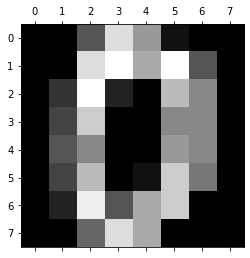

In [26]:
# Load data
digits = load_digits()
Images = digits.data
target = digits.target
print(target.shape)
plt.gray()
plt.matshow(digits.images[0])
plt.show()

In [37]:
class MLP(nn.Module):
    """
    Multi-layer Perceptron
    """
    nhidden_units: int
    nlayers = 1
    nclasses = 10 # number of categories 
    
    def setup(self):
        self.layers = [nn.Dense(self.nhidden_units) for n in range(self.nlayers)]
        self.final_layer = nn.Dense(self.nclasses)
        
    @nn.compact
    def __call__(self, x):
        for k, lyr in enumerate(self.layers):
            x = lyr(x)
            x = nn.relu(x)
        x = self.final_layer(x)
        x = nn.activation.softmax(x)
        return x
    
# initializing the optimizer
learning_rate = 1e-3
optx = optax.adam(learning_rate=learning_rate)

The target values we loaded are integers. We now write a code to one-hot encode them. For example, the category "1" would become [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0].

In [38]:
print(target[0])
def one_hot_encoder(x):
    nclasses = 10
    out = np.zeros((x.shape[0], nclasses))
    for i, x_ in enumerate(x):
        out[i,x_] = 1.
    return out
target_oh = one_hot_encoder(target)
# test
print(f"target value: {target[40]}, corresponding one-hot vector: {target_oh[40,:]}")

0
target value: 8, corresponding one-hot vector: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


## Fitting using a affine mappings

In [45]:
x_train, x_test, y_train, y_test = train_test_split(Images, target_oh, test_size=0.33, random_state=42)
print(x_train.shape, y_train.shape)
# initialize the neural network 
model = MLP(50)
params = model.init(jax.random.PRNGKey(0), x_test)
opt_state = optx.init(params)

# define the loss function 
@jax.jit
def cat_cross_entropy(params, x, y_true):
    """
    Categorical cross entropy 
    """
    y_pred = model.apply(params, x)
    loss_per_example = jnp.sum(-y_true*jnp.log(y_pred), axis=1)
    return jnp.mean(loss_per_example)

loss_fn = cat_cross_entropy
loss_grad_fn = jax.value_and_grad(cat_cross_entropy) # a function to evaluate the function and its gradient)

# training loop
n_epochs = 1000 #number of training epochs 
for e in range(n_epochs):
    loss_val, grad = loss_grad_fn(params, x_train, y_train)
    updates, opt_state = optx.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    if e % 100 == 0:
        print(f"epoch: {e}, loss function: {loss_val}")

(1203, 64) (1203, 10)
lossperex: (1203,)
epoch: 0, loss function: 6.700168132781982
epoch: 100, loss function: 0.19415205717086792
epoch: 200, loss function: 0.06052875146269798
epoch: 300, loss function: 0.0282761063426733
epoch: 400, loss function: 0.01623375341296196
epoch: 500, loss function: 0.010530908592045307
epoch: 600, loss function: 0.007389646954834461
epoch: 700, loss function: 0.005472120828926563
epoch: 800, loss function: 0.004207364283502102
epoch: 900, loss function: 0.0033350656740367413


Test the learned function on some random input.

In [53]:
sample = np.random.randint(low=0, high=x_test.shape[0], size=(1,))
y_pred = np.argmax(model.apply(params, x_test[sample,:]))
print(f"ture value: {np.argmax(y_test[sample,:])} predicted: {y_pred}")


ture value: 9 predicted: 9


Evaluate the training and test errors.

In [55]:
tr_loss = cat_cross_entropy(params, x_train, y_train)
te_loss = cat_cross_entropy(params, x_test, y_test)
print(f"training loss: {tr_loss}, test loss: {te_loss}")

lossperex: (594,)
training loss: 0.0027055542450398207, test loss: 0.11141058057546616


We now evaluate the training and test error. Does the model suffer from overfitting? from underfitting? from both?

One might argue that the curse of dimensionality is resulting from the fact that the basis we are using in multiple dimensions is a direct-product basis. To test the influence of this we not try to evaluate the accuracy of the model using a dimension-free prunning of the direct-product basis set. This prunnign is based on randomly sampling a subset of the full-direct product basis. 